# Import libraries

In [1]:
from semseg_functions import load_imgs_labels,train_model,make_predictions,load_model,run_and_visualize_layer_activation,show_filters
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import torch, cv2
from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/CedarsAIProject3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]
no_nucleus=(labels==2).sum(axis=(1,2))==0
images=images[~no_nucleus]
labels=labels[~no_nucleus]

X_train,X_test,Y_train,Y_test=train_test_split(images,labels,test_size=0.2,stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),random_state=42)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.2,stratify=Y_train.mean((1,2))>=np.median(Y_train.mean((1,2))),random_state=42)
X_train,X_val,X_test,Y_train,Y_val,Y_test=torch.FloatTensor(X_train).permute((0,3,1,2)),torch.FloatTensor(X_val).permute((0,3,1,2)),torch.FloatTensor(X_test).permute((0,3,1,2)),torch.LongTensor(Y_train),torch.LongTensor(Y_val),torch.LongTensor(Y_test)

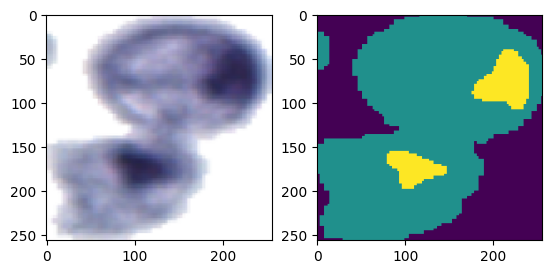

In [3]:
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(labels[0])

# Train model

In [4]:
model=train_model(X_train,Y_train,X_val,Y_val, encoder_name="resnet34", model_key="FPN", n_epochs=25)

Training: Epoch 1, Batch 0, Loss: 1.33
Training: Epoch 1, Batch 1, Loss: 1.043
Training: Epoch 1, Batch 2, Loss: 0.755
Training: Epoch 1, Batch 3, Loss: 0.66
Training: Epoch 1, Batch 4, Loss: 0.599
Training: Epoch 1, Batch 5, Loss: 0.581
Training: Epoch 1, Batch 6, Loss: 0.627
Training: Epoch 1, Batch 7, Loss: 0.58
Training: Epoch 1, Batch 8, Loss: 0.552
Training: Epoch 1, Batch 9, Loss: 0.458
Training: Epoch 1, Batch 10, Loss: 0.524
Training: Epoch 1, Batch 11, Loss: 0.437
Training: Epoch 1, Batch 12, Loss: 0.417
Training: Epoch 1, Batch 13, Loss: 0.511
Training: Epoch 1, Batch 14, Loss: 0.408
Training: Epoch 1, Batch 15, Loss: 0.335
Training: Epoch 1, Batch 16, Loss: 0.557
Training: Epoch 1, Batch 17, Loss: 0.37
Training: Epoch 1, Batch 18, Loss: 0.408
Training: Epoch 1, Batch 19, Loss: 0.342
Val: Epoch 1, Loss: 199.334
Training: Epoch 2, Batch 0, Loss: 0.312
Training: Epoch 2, Batch 1, Loss: 0.39
Training: Epoch 2, Batch 2, Loss: 0.326
Training: Epoch 2, Batch 3, Loss: 0.331
Trainin

# Predict on held out test

In [9]:
y_val_pred=make_predictions(X_val, encoder_name="resnet34", model_key="FPN")#,model=model)#model=None)
y_test_pred=make_predictions(X_test, encoder_name="resnet34", model_key="FPN")#,model=model)#model=None)

In [10]:
y_val_pred_lbls=y_val_pred.argmax(1)
y_test_pred_lbls=y_test_pred.argmax(1)

# Report segmentation model performance

In [11]:
from sklearn.metrics import classification_report

In [12]:
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    735746
           1       0.91      0.91      0.91    888107
           2       0.85      0.88      0.86    407763

    accuracy                           0.92   2031616
   macro avg       0.91      0.92      0.91   2031616
weighted avg       0.92      0.92      0.92   2031616



In [13]:
print(classification_report(Y_test.numpy().flatten(),y_test_pred_lbls.flatten()))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    906849
           1       0.90      0.88      0.89   1087940
           2       0.82      0.85      0.83    561115

    accuracy                           0.91   2555904
   macro avg       0.90      0.90      0.90   2555904
weighted avg       0.91      0.91      0.91   2555904



# Compare true and predicted NC ratios

In [14]:
nucleus_val_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==2).sum(axis=1)
cytoplasm_val_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==1).sum(axis=1)
nc_ratio_val_pred=nucleus_val_pred/(nucleus_val_pred+cytoplasm_val_pred)

nucleus_test_pred=(y_test_pred_lbls.reshape(y_test_pred_lbls.shape[0],-1)==2).sum(axis=1)
cytoplasm_test_pred=(y_test_pred_lbls.reshape(y_test_pred_lbls.shape[0],-1)==1).sum(axis=1)
nc_ratio_test_pred=nucleus_test_pred/(nucleus_test_pred+cytoplasm_test_pred)

In [15]:
nucleus_val_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_val_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_val_true=(nucleus_val_true/(nucleus_val_true+cytoplasm_val_true)).numpy()

nucleus_test_true=(Y_test.reshape(Y_test.shape[0],-1)==2).sum(axis=1)
cytoplasm_test_true=(Y_test.reshape(Y_test.shape[0],-1)==1).sum(axis=1)
nc_ratio_test_true=(nucleus_test_true/(nucleus_test_true+cytoplasm_test_true)).numpy()

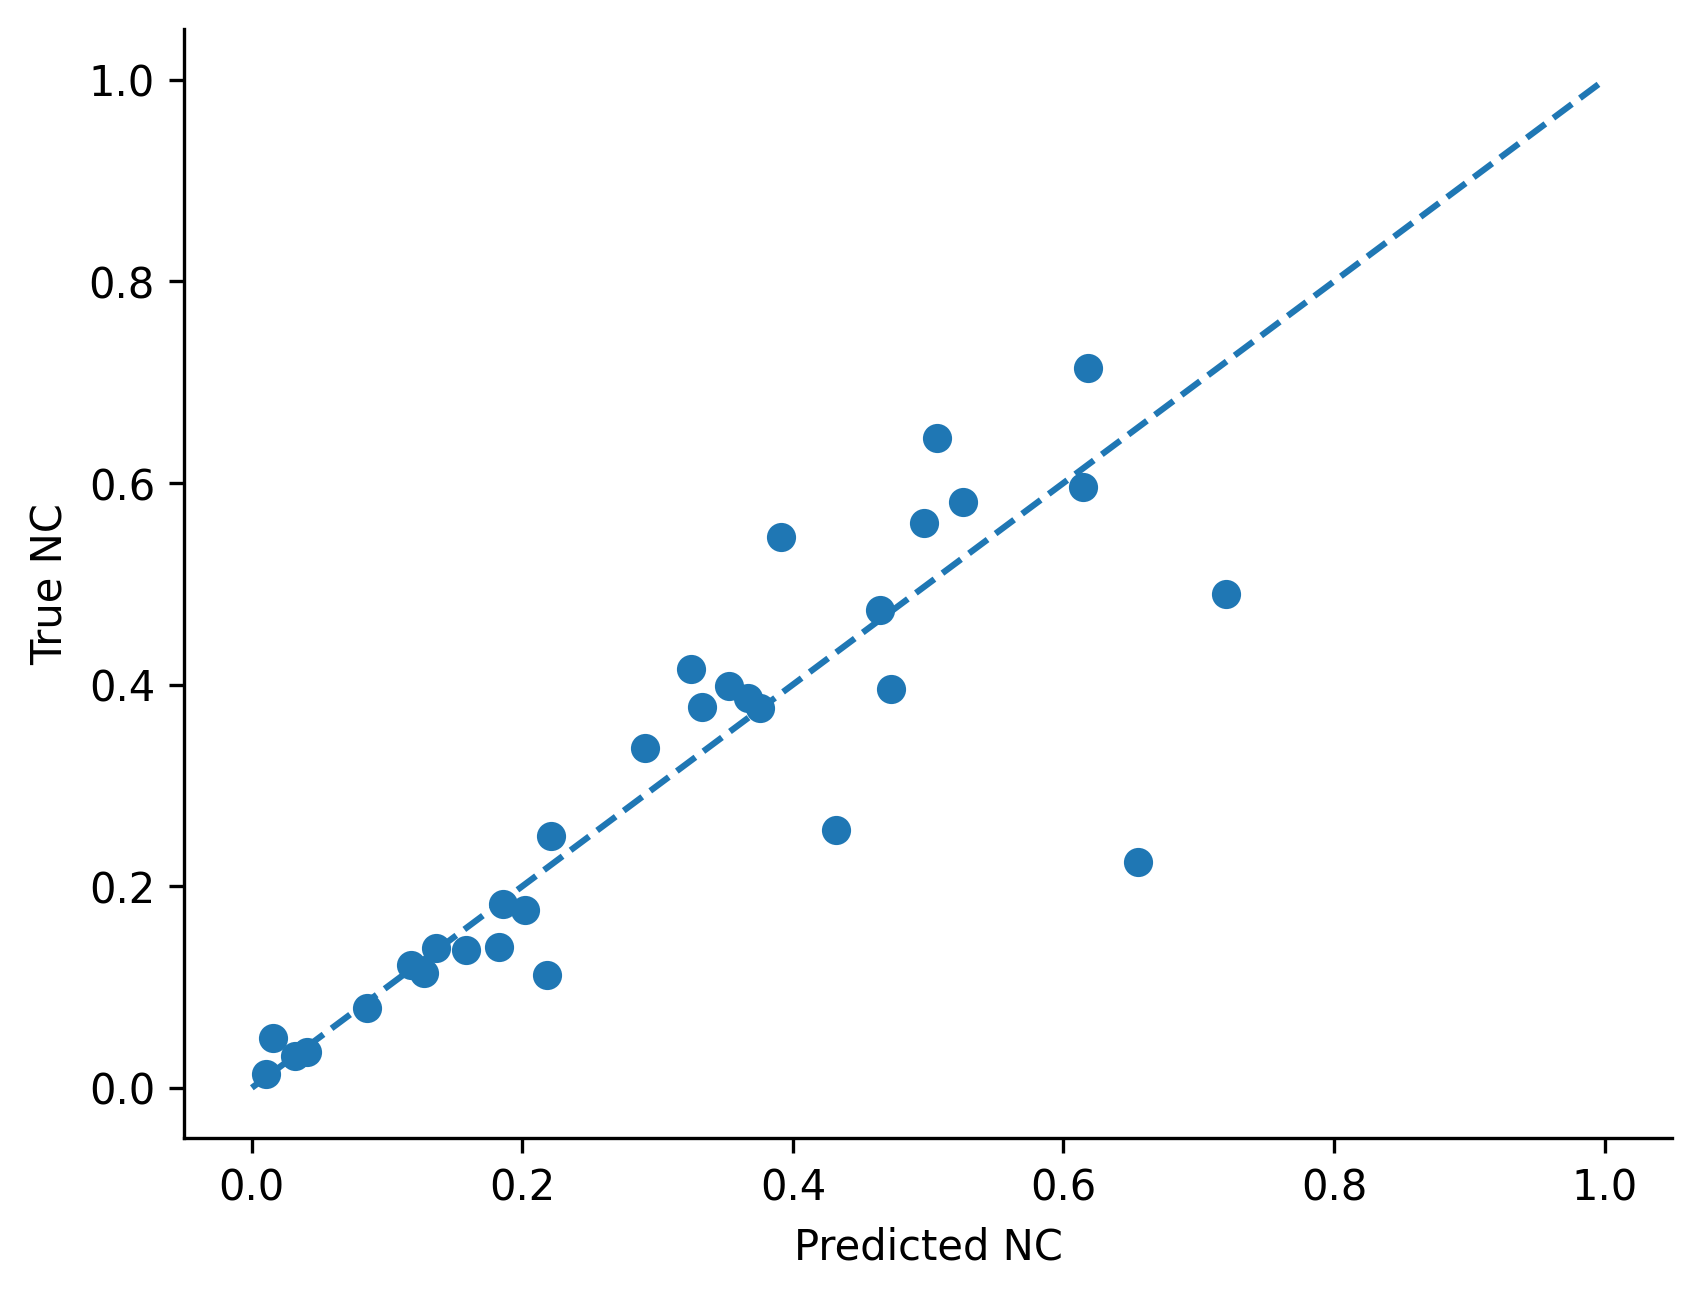

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(nc_ratio_val_pred,nc_ratio_val_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

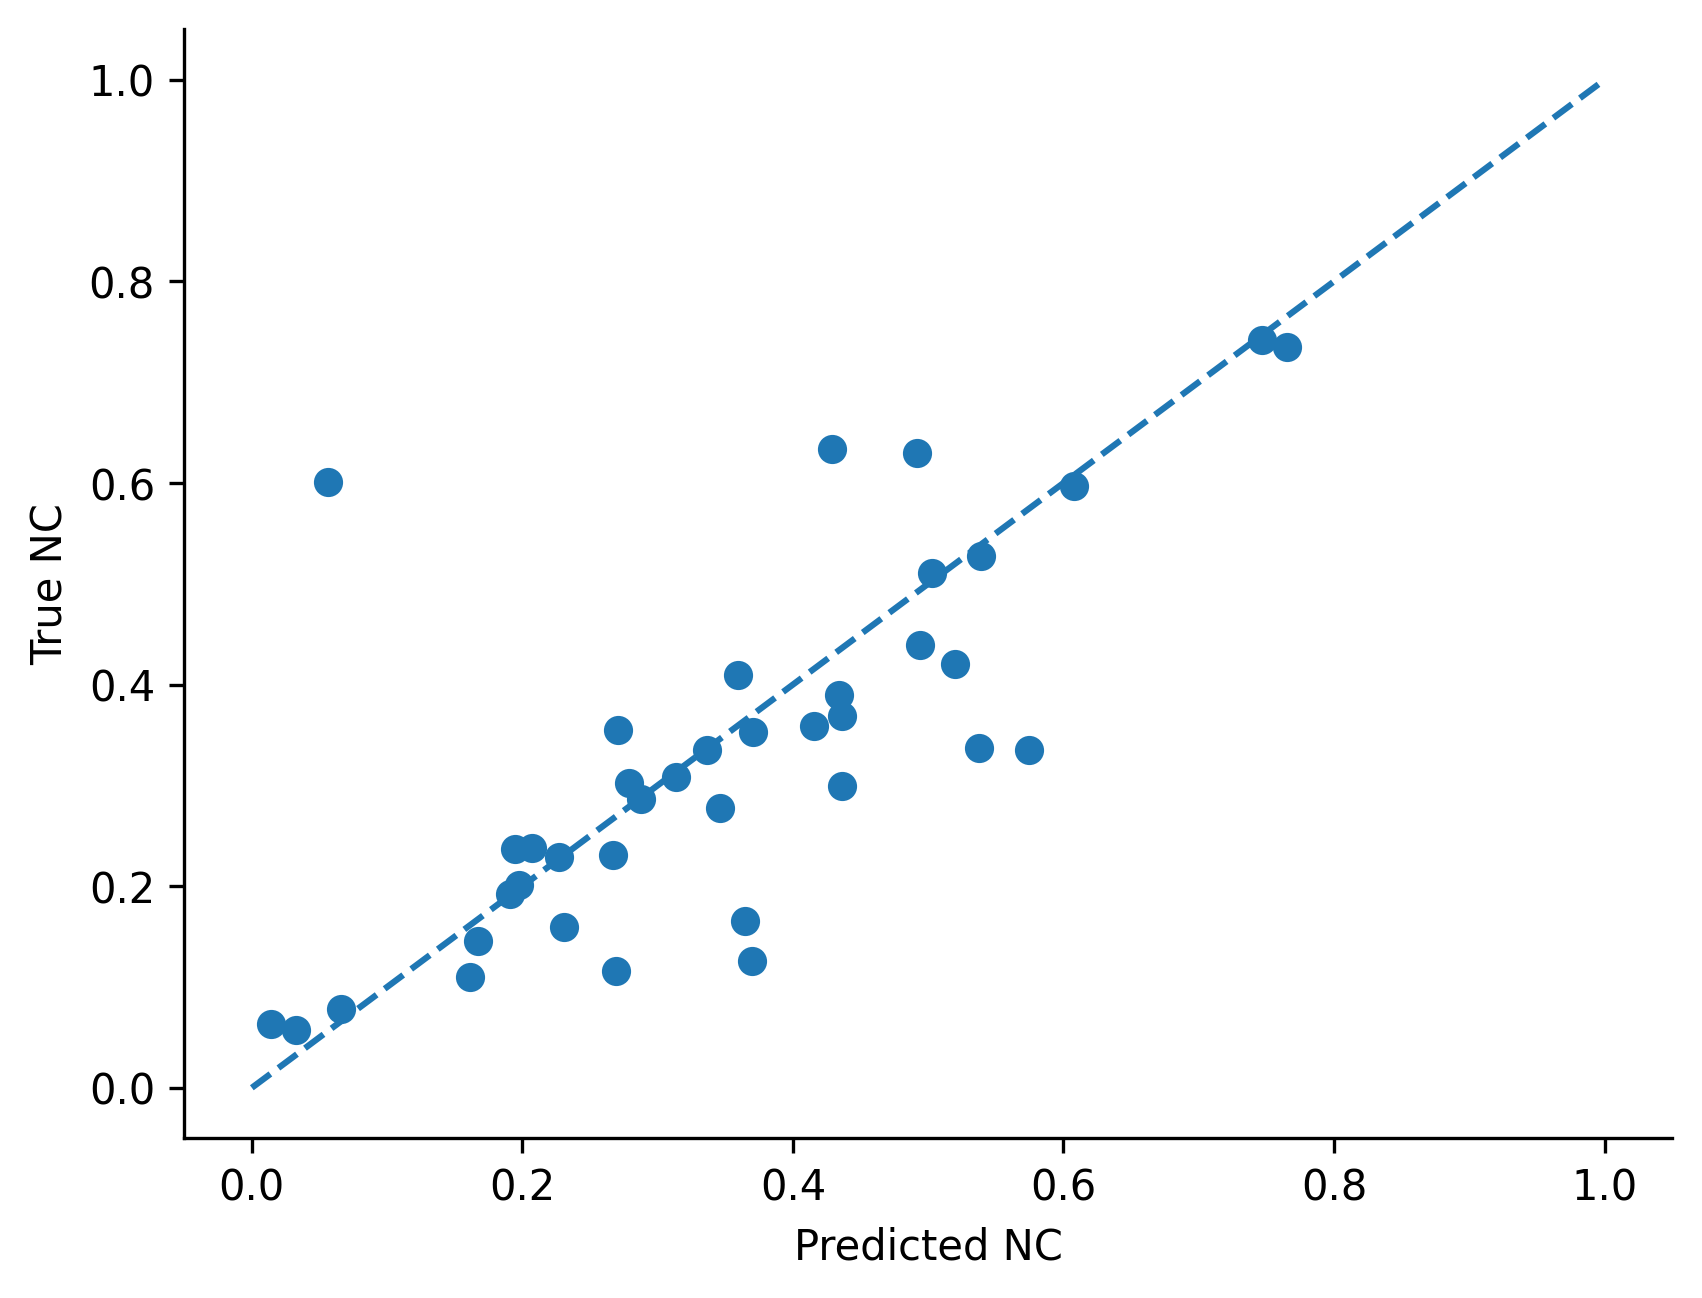

In [17]:
plt.scatter(nc_ratio_test_pred,nc_ratio_test_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

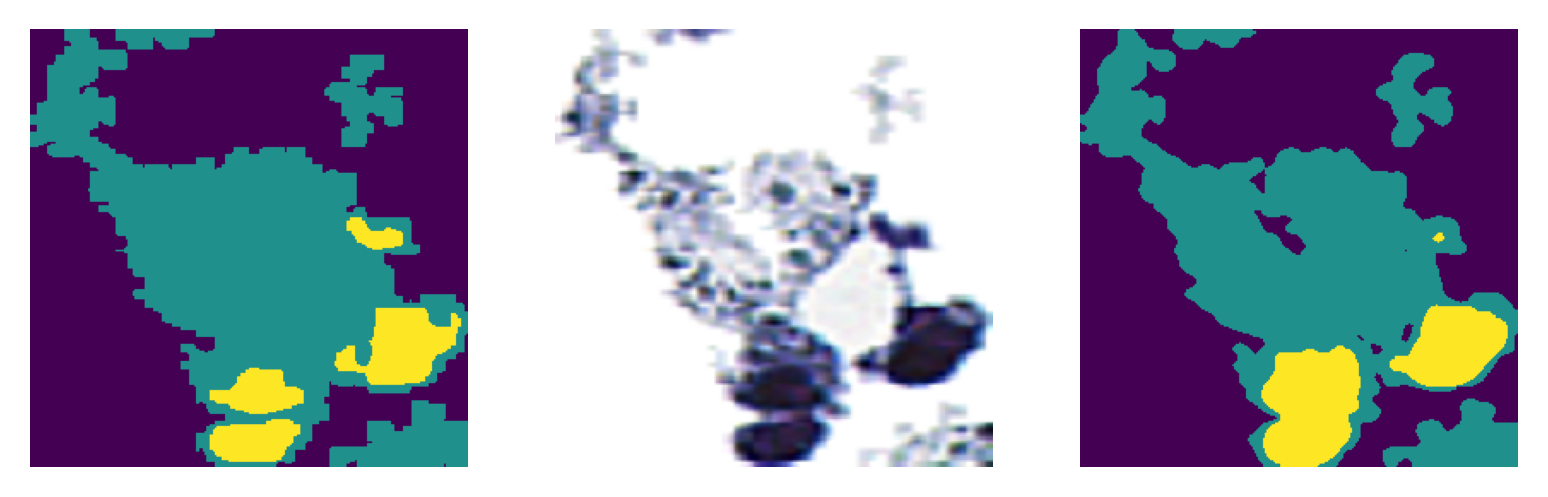

In [18]:
# ! mkdir DL_result_imgs
for idx in range(len(X_val)):
    plt.subplot(131)
    plt.imshow(Y_val[idx])
    plt.axis("off")
    plt.subplot(132)
    plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(y_val_pred_lbls[idx])
    plt.axis("off")
    plt.savefig(f"DL_result_imgs/urothelial_cell_{idx}.png")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

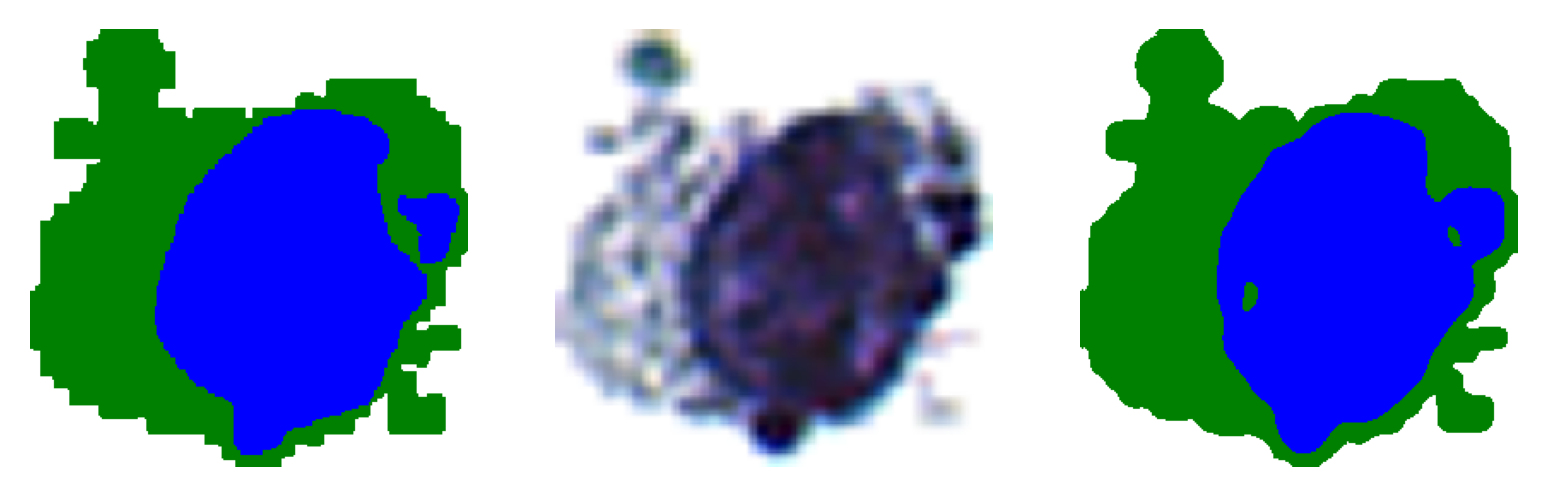

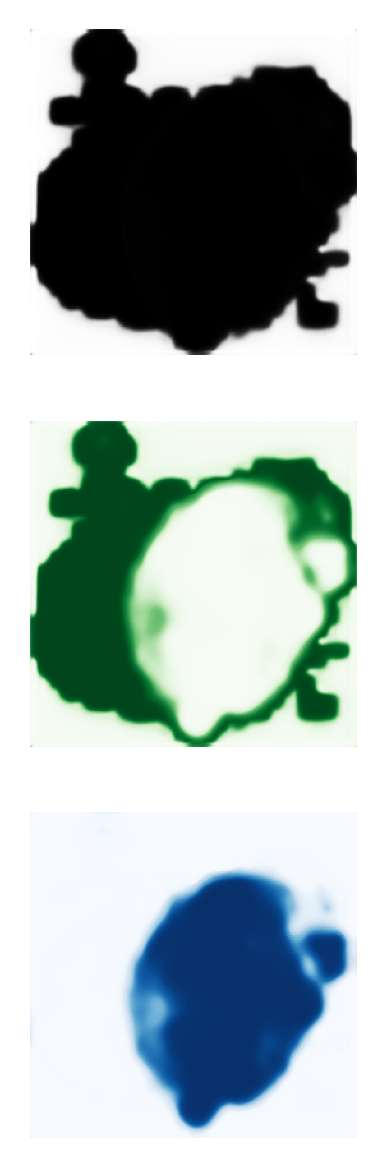

In [19]:
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt

idx=22
plt.figure()
plt.subplot(131)
plt.imshow(Y_val[idx], cmap=plt.matplotlib.colors.ListedColormap(['white', 'green', 'blue']))
plt.axis("off")
plt.subplot(132)
plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
plt.axis("off")
plt.subplot(133)
plt.imshow(y_val_pred_lbls[idx], cmap=plt.matplotlib.colors.ListedColormap(['white', 'green', 'blue']))
plt.axis("off")
plt.figure()
plt.subplot(311)
plt.imshow(y_val_pred[idx][0], cmap="Greys_r")
plt.axis("off")
plt.subplot(312)
plt.imshow(y_val_pred[idx][1], cmap="Greens")
plt.axis("off")
plt.subplot(313)
plt.imshow(y_val_pred[idx][2], cmap="Blues")
plt.axis("off")

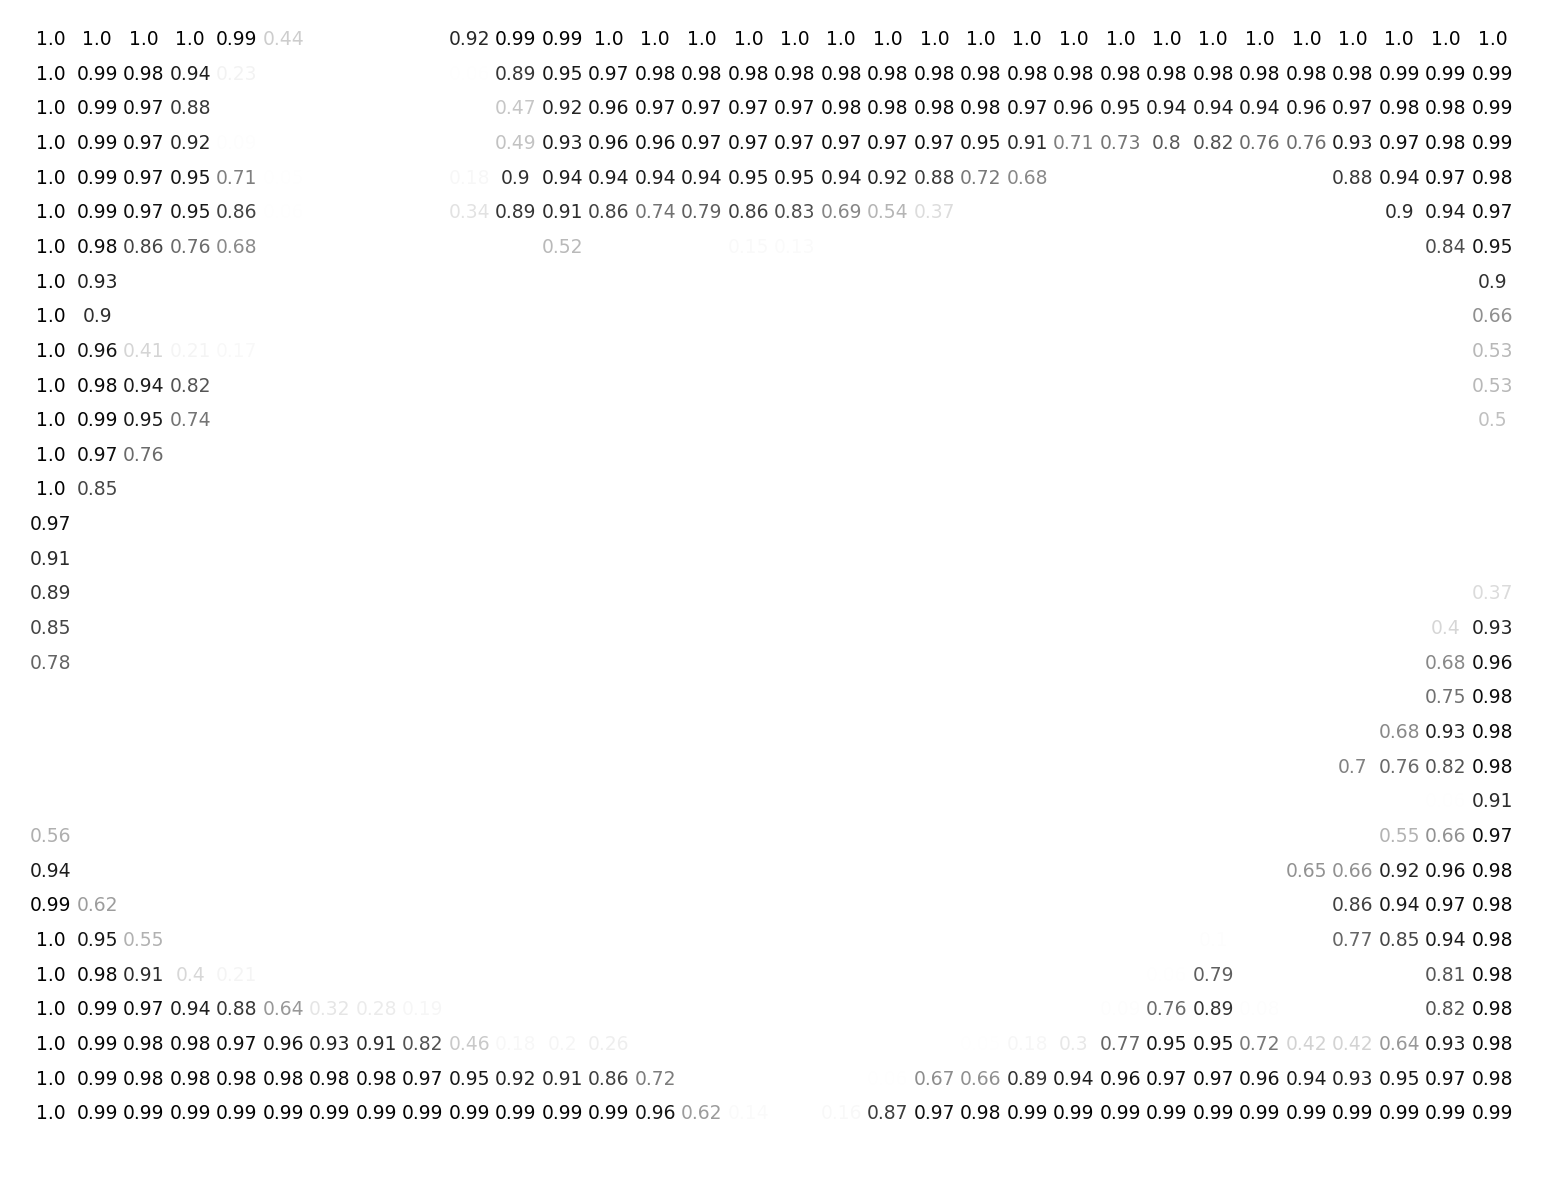

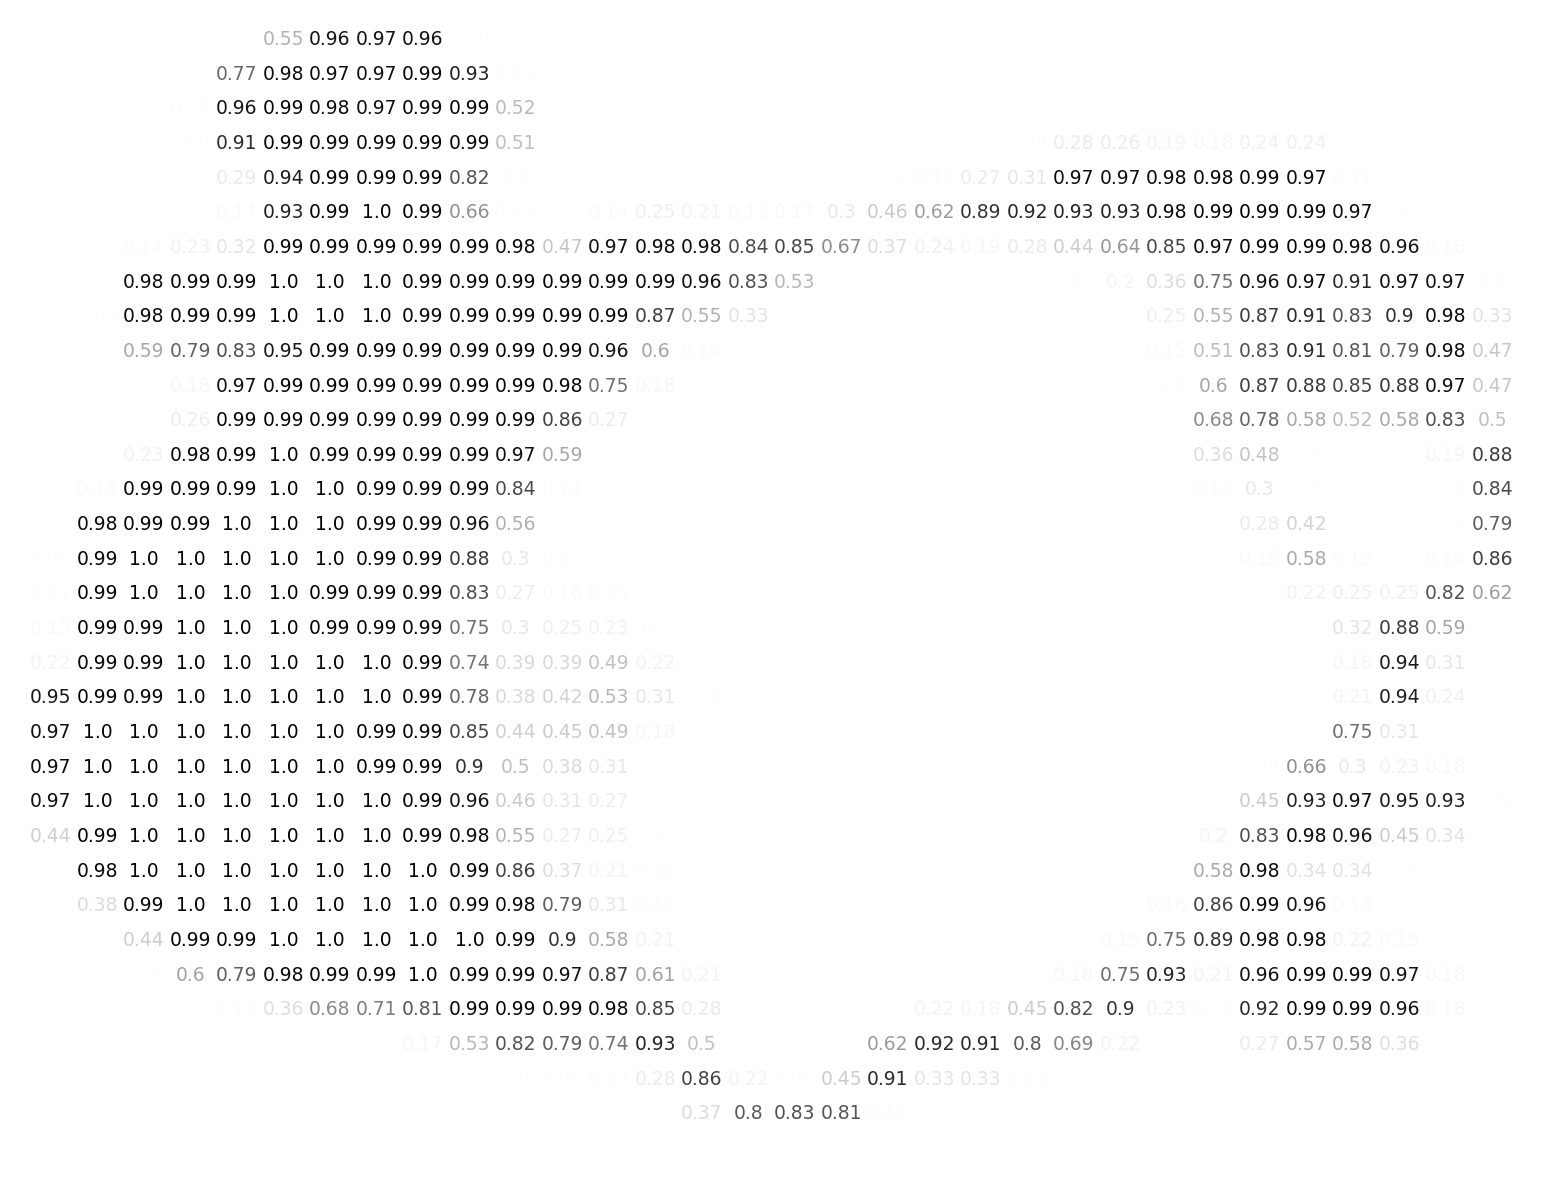

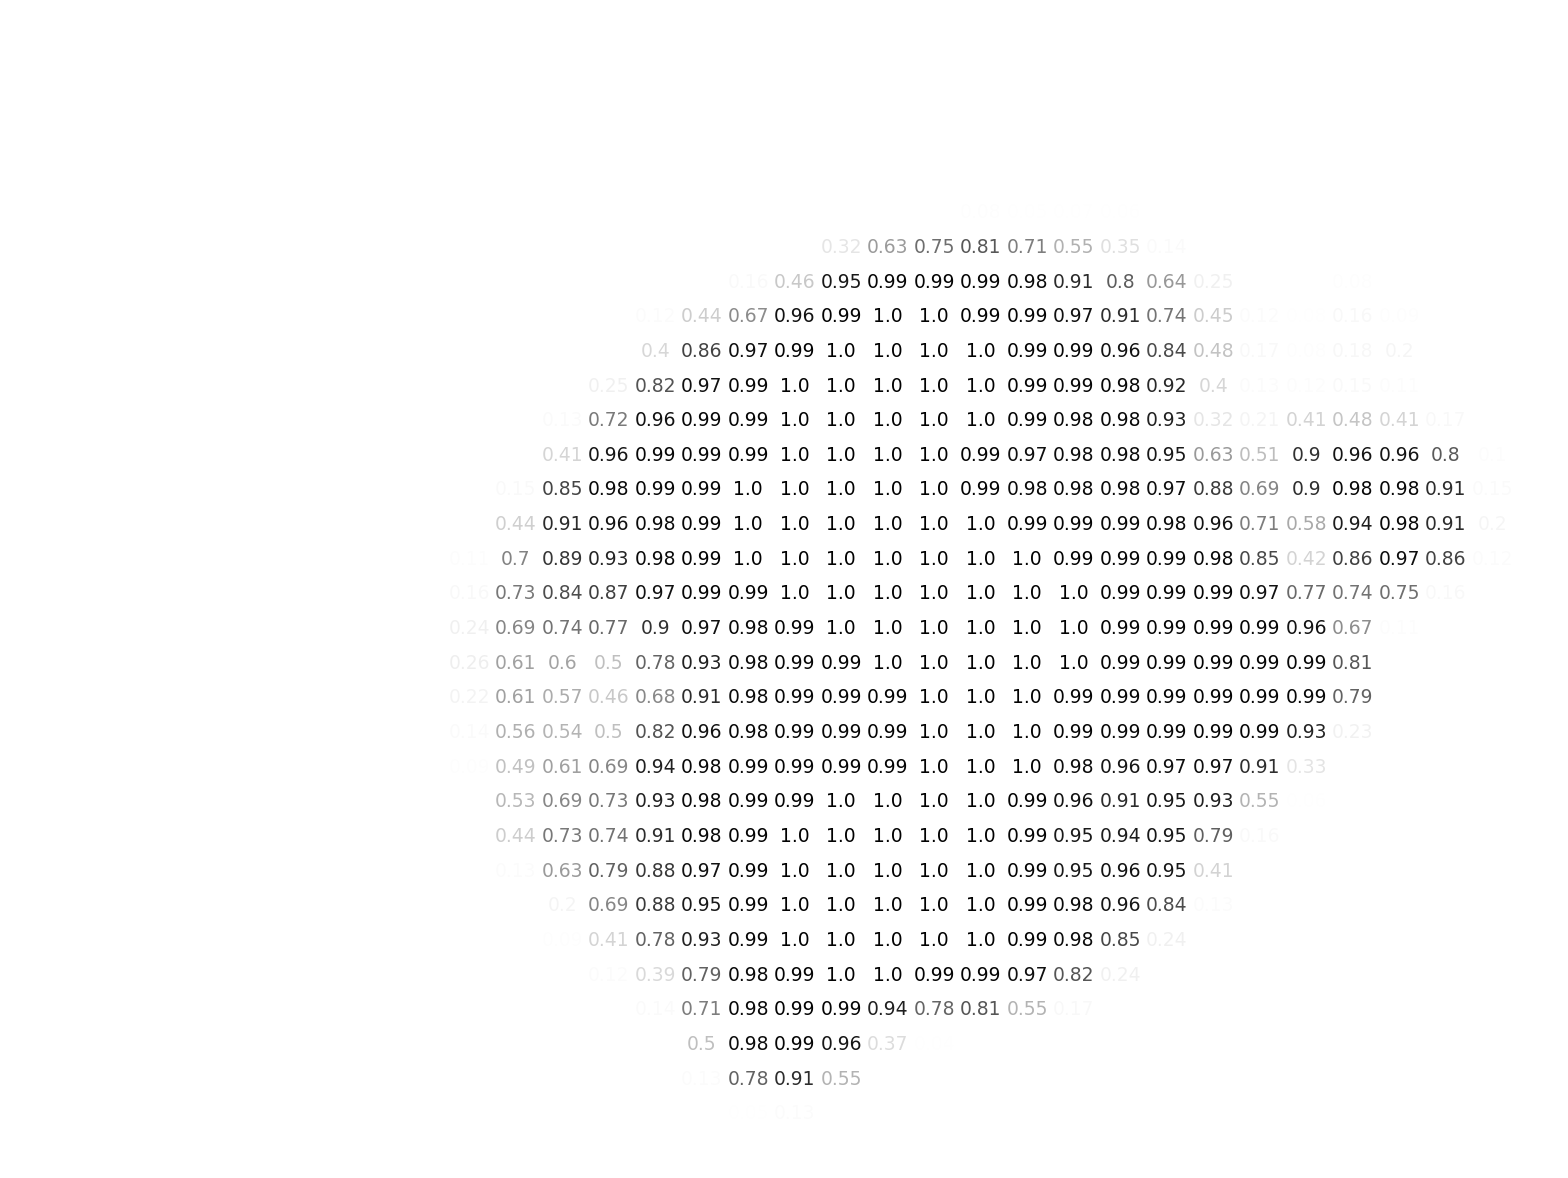

In [20]:

for class_idx in range(y_val_pred[idx].shape[0]):
    img_gray_small=cv2.resize(y_val_pred[idx][class_idx],None,fx=1/8,fy=1/8)
    plt.figure()
    for i in range(img_gray_small.shape[0]):
        for j in range(img_gray_small.shape[1]):
            text = plt.text(j/img_gray_small.shape[0], i/img_gray_small.shape[1], str(round(img_gray_small[i, j],2)),
                        ha="center", va="center", color="k", alpha=(img_gray_small[i, j])**2, fontsize=4.5)#**2/2
    plt.axis("off")
    plt.gca().invert_yaxis()

In [21]:
# correlation - true vs predicted
spearmanr(nc_ratio_val_pred,nc_ratio_val_true)

SignificanceResult(statistic=np.float64(0.8919354838709678), pvalue=np.float64(1.6469398667678045e-11))

In [22]:
# error - true vs predicted
np.abs(nc_ratio_val_pred-nc_ratio_val_true).mean()

np.float64(0.06430370652945708)

In [23]:
print(spearmanr(nc_ratio_test_pred,nc_ratio_test_true))
print(np.abs(nc_ratio_test_pred-nc_ratio_test_true).mean())

SignificanceResult(statistic=np.float64(0.7475708502024291), pvalue=np.float64(4.5443578447707984e-08))
0.07814640854172236


(1440, 1920, 4)
(1440, 1920, 4)
(1440, 1920, 4)


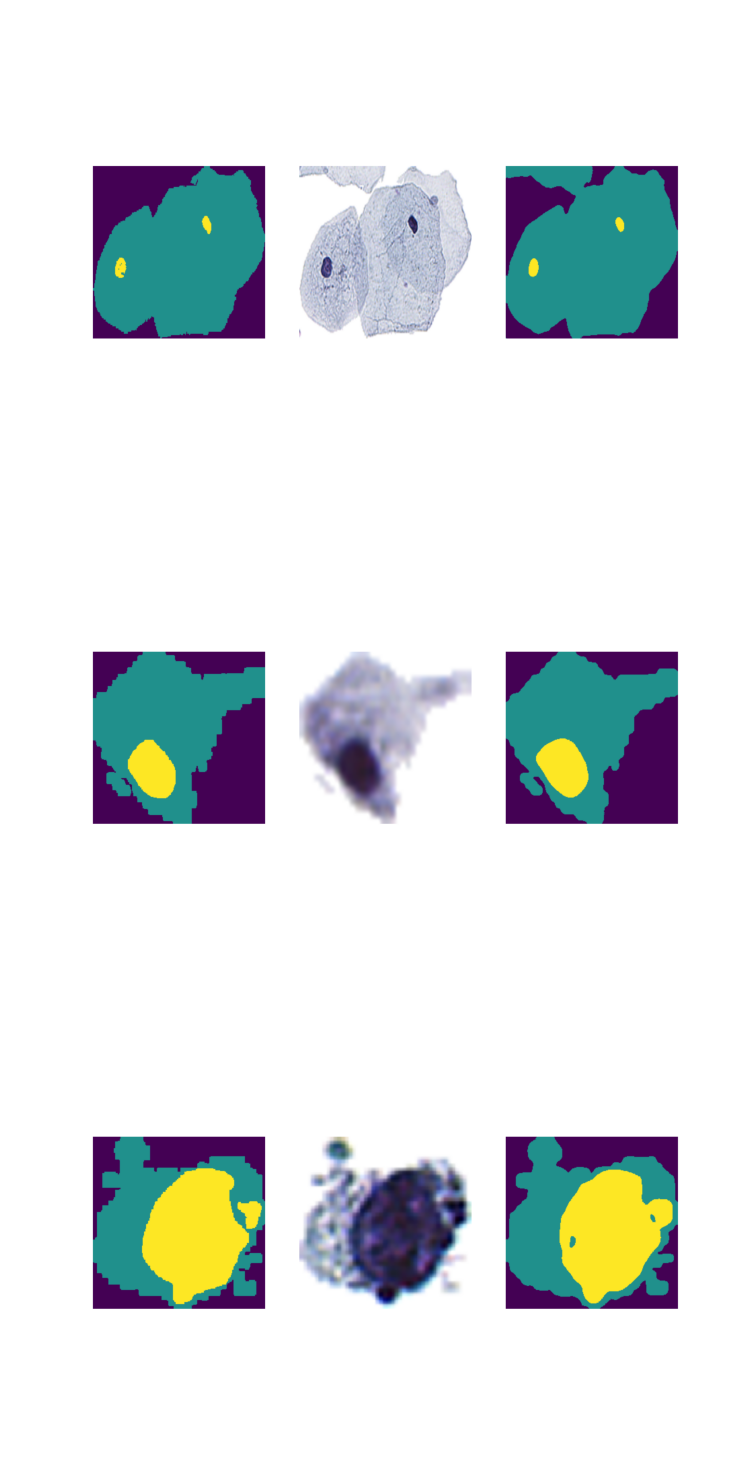

In [24]:
import matplotlib.pyplot as plt

result_images = [
    "DL_result_imgs/urothelial_cell_11.png",
    "DL_result_imgs/urothelial_cell_21.png", 
    "DL_result_imgs/urothelial_cell_22.png"
]

# Create a single figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 5))

# Plot each image in a subplot
for ax, img_path in zip(axes, result_images):
    im_=plt.imread(img_path)
    print(im_.shape)
    ax.imshow(im_[160:im_.shape[0]-160,80:im_.shape[1]-80])
    ax.axis('off')

plt.tight_layout()
plt.show()


## Bonus: Plot the neural network filters.

In [25]:
model=load_model(encoder_name="resnet34", model_key="FPN")


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

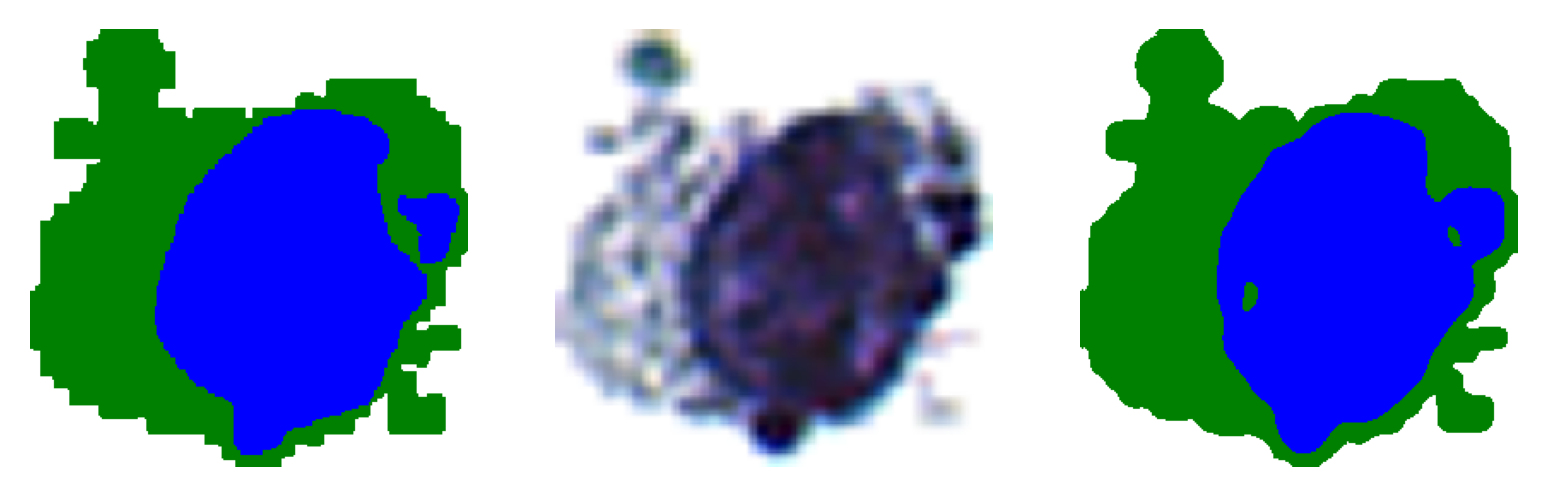

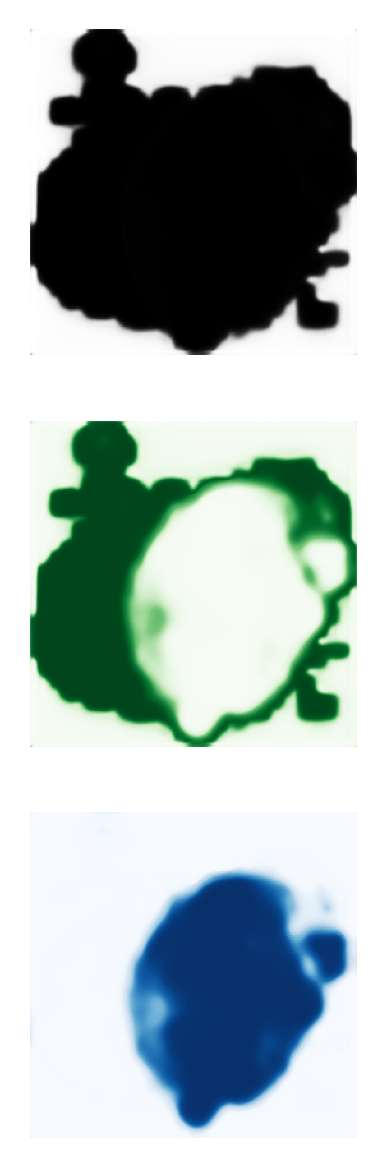

In [26]:
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt

idx=22
plt.figure()
plt.subplot(131)
plt.imshow(Y_val[idx], cmap=plt.matplotlib.colors.ListedColormap(['white', 'green', 'blue']))
plt.axis("off")
plt.subplot(132)
plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
plt.axis("off")
plt.subplot(133)
plt.imshow(y_val_pred_lbls[idx], cmap=plt.matplotlib.colors.ListedColormap(['white', 'green', 'blue']))
plt.axis("off")
plt.figure()
plt.subplot(311)
plt.imshow(y_val_pred[idx][0], cmap="Greys_r")
plt.axis("off")
plt.subplot(312)
plt.imshow(y_val_pred[idx][1], cmap="Greens")
plt.axis("off")
plt.subplot(313)
plt.imshow(y_val_pred[idx][2], cmap="Blues")
plt.axis("off")

In [4]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

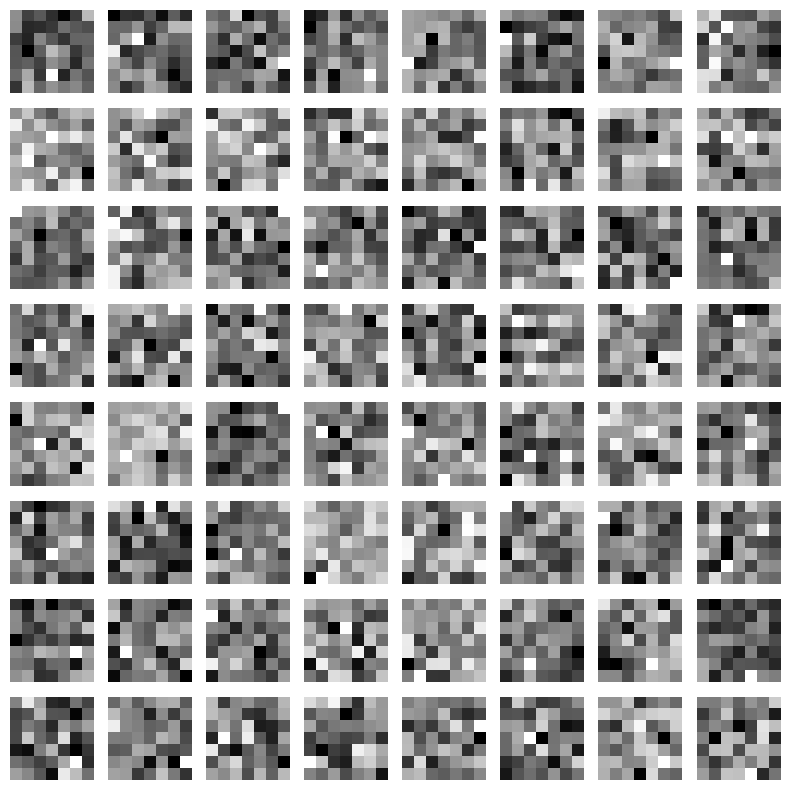

In [5]:
filters = model.encoder.conv1.weight
#.layer1[0].conv2.weight  # Shape: [out_channels, in_channels, height, width]
show_filters(filters)

In [6]:
dict(list(model.named_modules())).keys()

dict_keys(['', 'encoder', 'encoder.conv1', 'encoder.bn1', 'encoder.relu', 'encoder.maxpool', 'encoder.layer1', 'encoder.layer1.0', 'encoder.layer1.0.conv1', 'encoder.layer1.0.bn1', 'encoder.layer1.0.relu', 'encoder.layer1.0.conv2', 'encoder.layer1.0.bn2', 'encoder.layer1.1', 'encoder.layer1.1.conv1', 'encoder.layer1.1.bn1', 'encoder.layer1.1.relu', 'encoder.layer1.1.conv2', 'encoder.layer1.1.bn2', 'encoder.layer1.2', 'encoder.layer1.2.conv1', 'encoder.layer1.2.bn1', 'encoder.layer1.2.relu', 'encoder.layer1.2.conv2', 'encoder.layer1.2.bn2', 'encoder.layer2', 'encoder.layer2.0', 'encoder.layer2.0.conv1', 'encoder.layer2.0.bn1', 'encoder.layer2.0.relu', 'encoder.layer2.0.conv2', 'encoder.layer2.0.bn2', 'encoder.layer2.0.downsample', 'encoder.layer2.0.downsample.0', 'encoder.layer2.0.downsample.1', 'encoder.layer2.1', 'encoder.layer2.1.conv1', 'encoder.layer2.1.bn1', 'encoder.layer2.1.relu', 'encoder.layer2.1.conv2', 'encoder.layer2.1.bn2', 'encoder.layer2.2', 'encoder.layer2.2.conv1', 'en

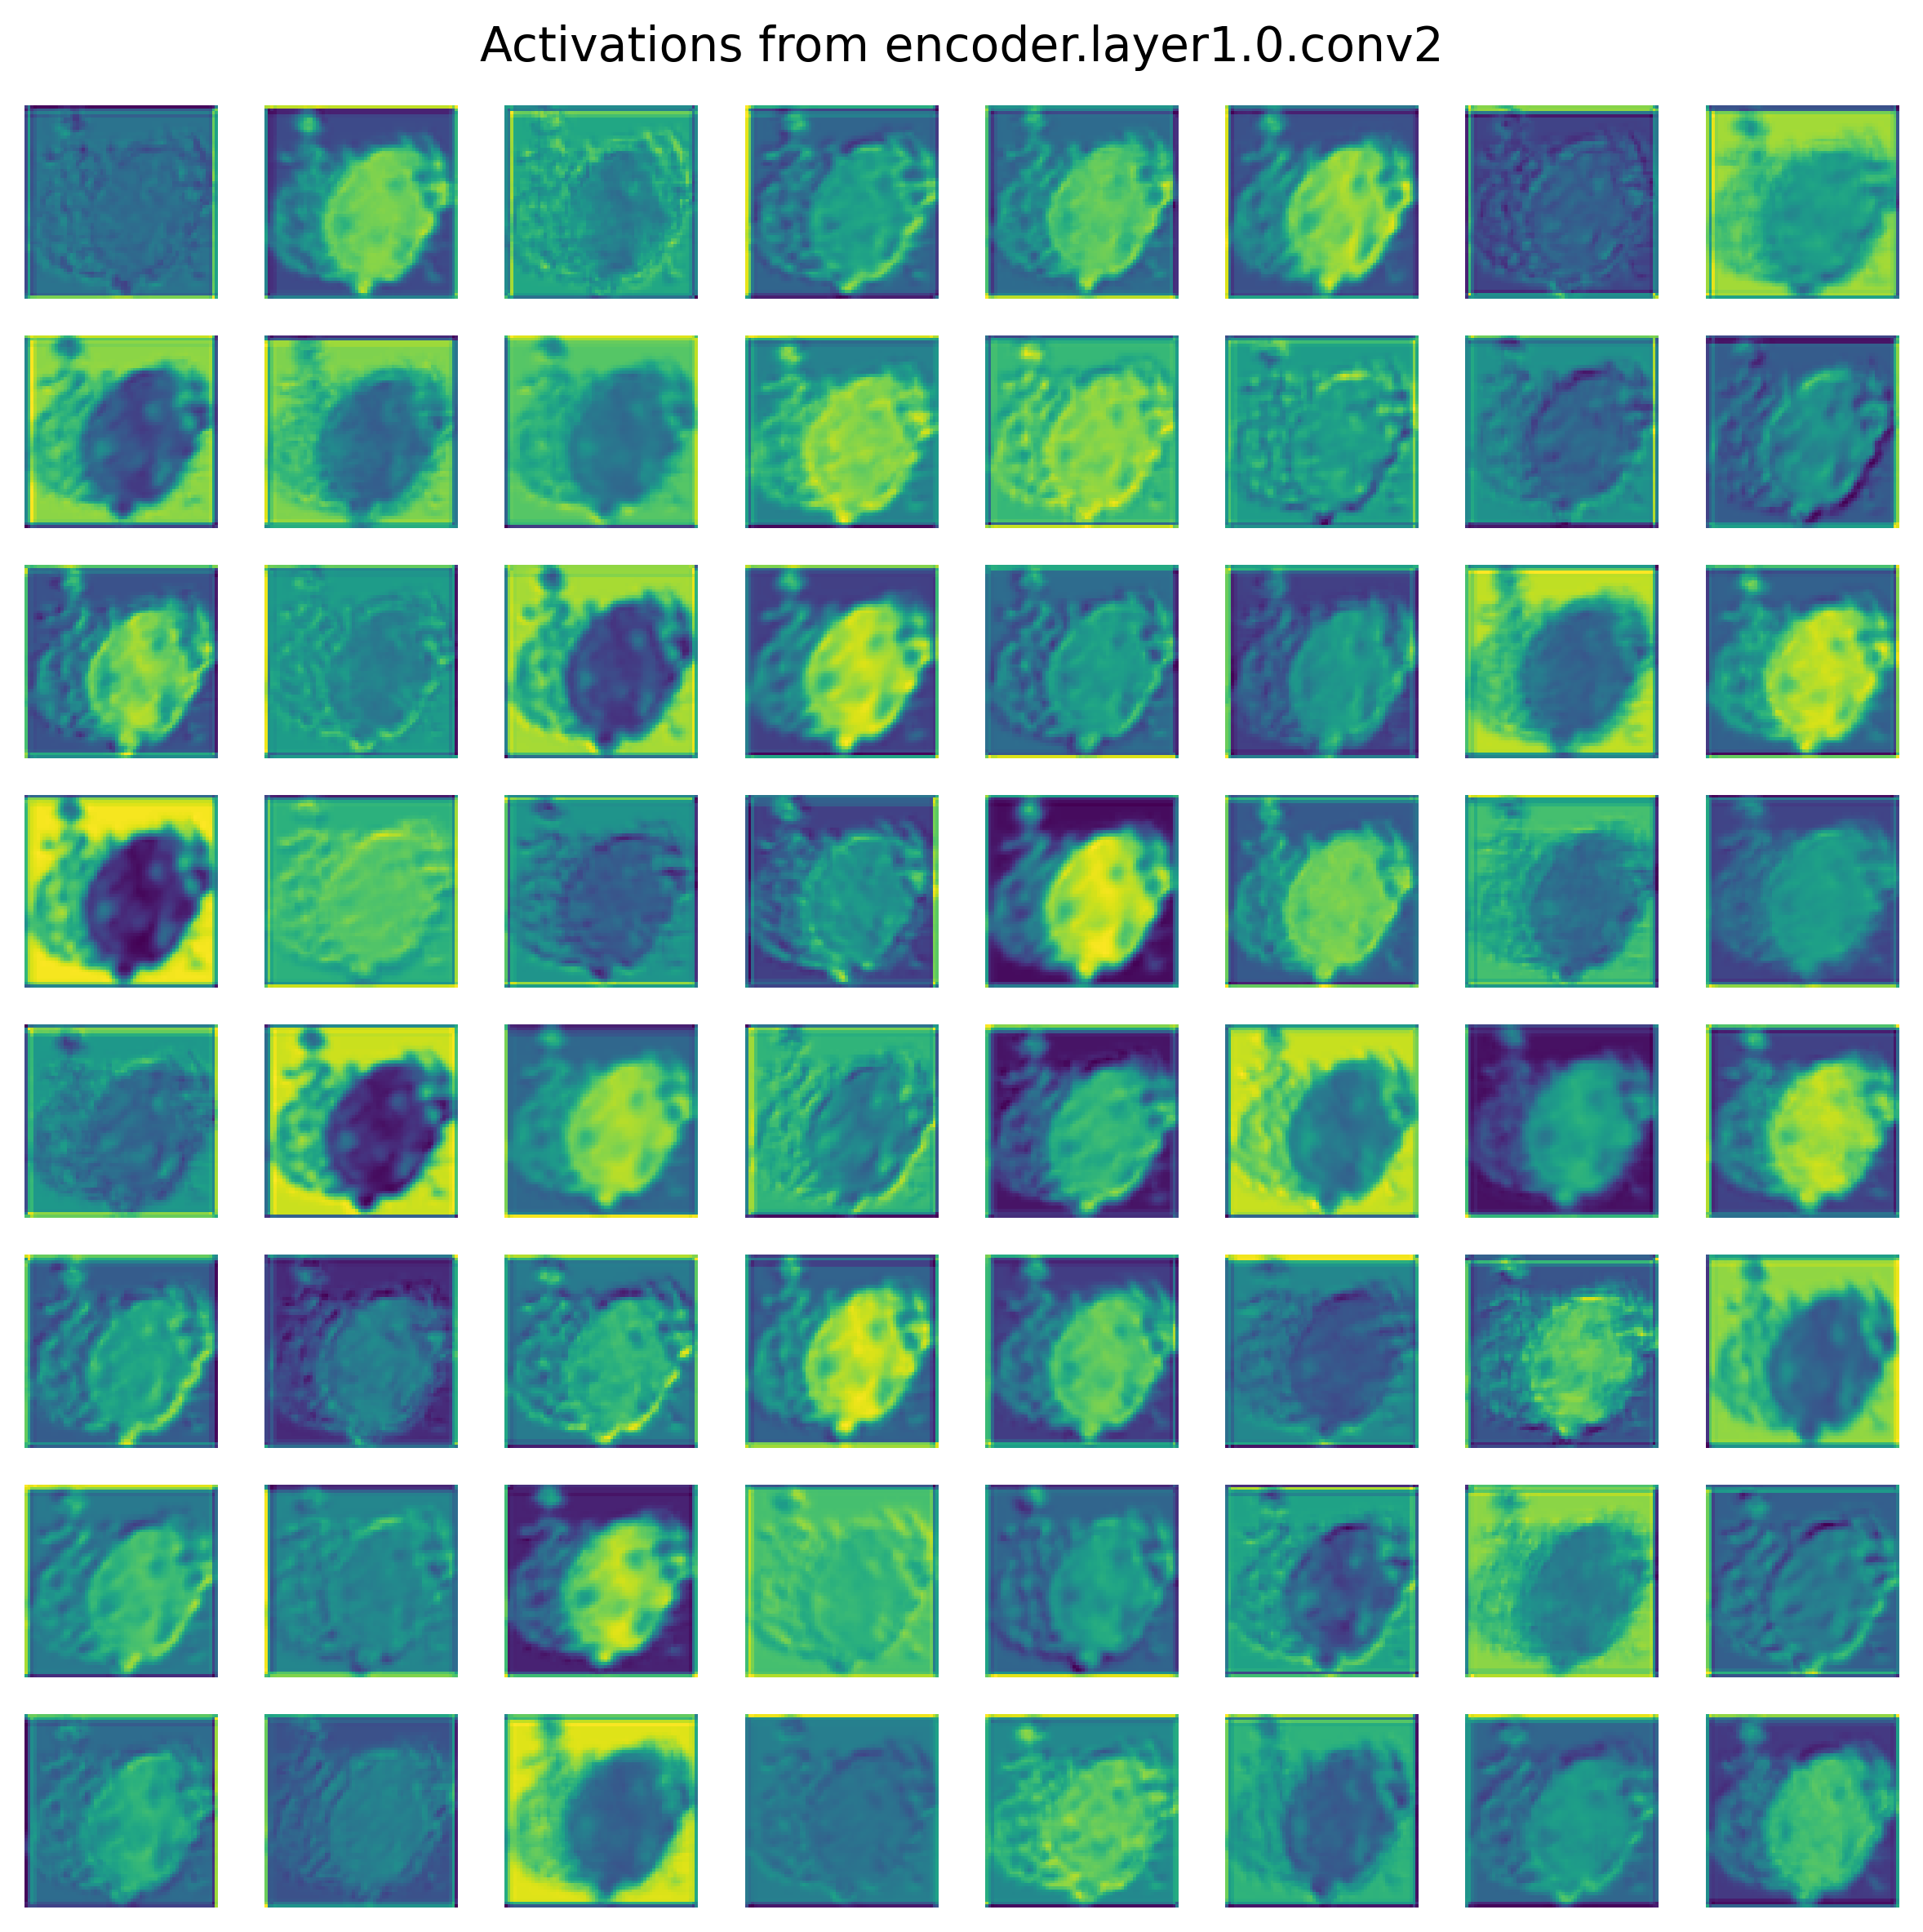

In [8]:
run_and_visualize_layer_activation(model,"encoder.layer1.0.conv2",X_val[idx].unsqueeze(0))